In [85]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

import yfinance as yf

from datetime import datetime, timedelta

import requests
import json

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
import yfinance as yf
from datetime import datetime, timedelta
import datetime



end_date = datetime.datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.datetime.today() - datetime.timedelta(days=365*20)).strftime('%Y-%m-%d')

tesla_data = yf.download('TSLA', start=start_date, end=end_date)
apple_data = yf.download('AAPL', start=start_date, end=end_date)
amazon_data = yf.download('AMZN', start=start_date, end=end_date)                                                                                       


#GOLD Data

gold_data = yf.download('GC=F', start=start_date, end=end_date)


#ETF's

api_key = '2YW9PTCOWXKLLTNS'

qqq_symbol = 'QQQ'
spdr_symbol = 'SPY'
ishr_symbol = 'IWM'

output_format = 'json'

base_url = 'https://www.alphavantage.co/query'

def fetch_etf_data(api_key, symbol, output_format, start_date, end_date):
    # Define the API parameters
    params = {
        'function': 'TIME_SERIES_DAILY',  # Daily time series data
        'symbol': symbol,
        'outputsize': 'full',  # Retrieve full historical data
        'datatype': output_format,
        'apikey': api_key,
        'start_date': start_date,  # Specify the start date
        'end_date': end_date      # Specify the end date
    }

    try:

        response = requests.get(base_url, params=params)
        data = response.json() if output_format == 'json' else response.text

        # Check for API request success
        if 'Time Series (Daily)' in data:
            return data['Time Series (Daily)']
        else:
            print("API request was not successful. Check your API key or symbol.")
            return None

    except Exception as e:
        print(f"An error occurred: {e}")
        return None


invesco_data = pd.DataFrame(fetch_etf_data(api_key, qqq_symbol, output_format, start_date, end_date))
ishares_data = pd.DataFrame(fetch_etf_data(api_key, ishr_symbol, output_format, start_date, end_date))
spdr_data = pd.DataFrame(fetch_etf_data(api_key, spdr_symbol, output_format, start_date, end_date))

spdr_data = spdr_data.T
ishares_data = ishares_data.T
invesco_data = invesco_data.T


#bitcoin

api_key = "5DyC56vN-RWdz61xD4-m"
url = f"https://www.quandl.com/api/v3/datasets/BCHAIN/MKPRU/data.json?start_date={start_date}&end_date={end_date}&api_key={api_key}"
response = requests.get(url)
bitcon_data = response.json()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


**LSTM PRICE PREDICTION**

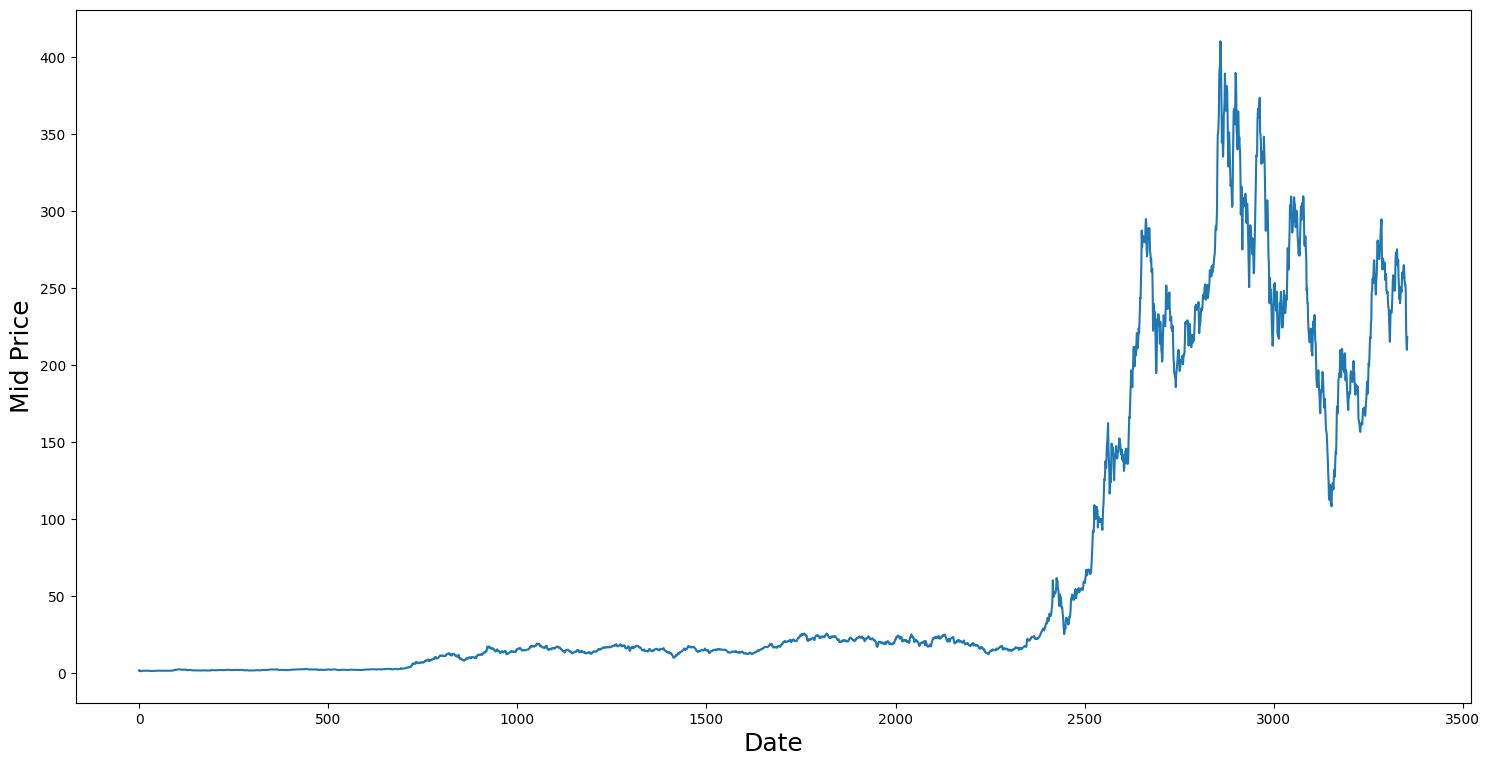

In [4]:
plt.figure(figsize = (18,9))
plt.plot(range(tesla_data.shape[0]),(tesla_data['Low']+tesla_data['High'])/2.0)

plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [3]:
import pandas_ta as ta
tesla_data["RSI"] = ta.rsi(tesla_data.Close, length=15)
#Exponential moving average with different time span
tesla_data["EMAF"] = ta.ema(tesla_data.Close, length=20)
tesla_data["EMAM"] = ta.ema(tesla_data.Close, length=100)
tesla_data["EMAS"] = ta.ema(tesla_data.Close, length=150)

#next day target price
tesla_data["Target"] = (tesla_data['Adj Close']-tesla_data["Open"]).shift(-1)
tesla_data["TargetClass"] = [1 if tesla_data["Target"][i] > 0 else 0 for i in range(len(tesla_data))]
tesla_data["NextCloseTarget"] = tesla_data["Adj Close"].shift(-1)


C:\Users\srdhr\AppData\Local\Temp\ipykernel_22068\3948879117.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tesla_data["TargetClass"] = [1 if tesla_data["Target"][i] > 0 else 0 for i in range(len(tesla_data))]


In [4]:
tesla_data.dropna(inplace=True)
tesla_data.reset_index(inplace=True)
tesla_data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)

In [5]:
tesla_data.head()

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,Target,TargetClass,NextCloseTarget
0,1.603333,1.608000,1.566667,1.606667,39.355771,1.704250,1.697052,1.576578,-0.026667,0,1.594000
1,1.620667,1.648667,1.569333,1.594000,38.612865,1.693750,1.695011,1.576809,-0.014667,0,1.596000
2,1.610667,1.612000,1.578000,1.596000,38.808267,1.684441,1.693051,1.577063,-0.012667,0,1.575333
3,1.588000,1.593333,1.543333,1.575333,37.487123,1.674049,1.690720,1.577040,0.001333,1,1.564000
4,1.562667,1.578000,1.548000,1.564000,36.752037,1.663568,1.688210,1.576867,-0.012667,0,1.538000


In [60]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.optimizers import Adam
 # Build and train the LSTM model
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

def fit_LSTM(data):
# Extract the 'Close' prices as the target variable
    prices = data.values.reshape(-1, 1)

    # Normalize the data using Min-Max scaling
    scaler = MinMaxScaler()
    prices_scaled = scaler.fit_transform(prices)

    # Define a function to create sequences for LSTM training
    def create_sequences(data, sequence_length):
        X, y = [], []
        for i in range(len(data) - sequence_length):
            X.append(data[i:i+sequence_length])
            y.append(data[i+sequence_length])
        return np.array(X), np.array(y)

    # Hyperparameters
    sequence_length = 60  # Adjust as needed
    train_ratio = 0.7
    validation_ratio = 0.1
    test_ratio = 0.2

    # Calculate split indices
    total_len = len(prices_scaled)
    train_split = int(total_len * train_ratio)
    validation_split = int(total_len * (train_ratio + validation_ratio))

    # Create sequences for training
    X, y = create_sequences(prices_scaled, sequence_length)

    # Split data into training, validation, and testing sets
    X_train, X_val, X_test = X[:train_split], X[train_split:validation_split], X[validation_split:]
    y_train, y_val, y_test = y[:train_split], y[train_split:validation_split], y[validation_split:]
 
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(sequence_length, 1)))
    model.add(Dense(units=1))

    es = EarlyStopping(patience=10, verbose=3)

    model.compile(loss='mse',
                optimizer=Adam(),
                metrics=['mean_absolute_error'])
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2, validation_data=(X_val, y_val), callbacks=es)

    y_pred = model.predict(X_test)

    # Inverse transform the scaled data to get actual prices
    y_test_actual = scaler.inverse_transform(y_test)
    y_pred_actual = scaler.inverse_transform(y_pred)

    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    mse = mean_squared_error(y_test_actual, y_pred_actual)
    rmse = np.sqrt(mse)

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    lst_output=[]
    n_steps=60
    i=0
    x_input = prices_scaled[validation_split:][-60:].reshape(1,-1)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()


    while(i<30):
        
        if(len(temp_input)>60):
            
            x_input=np.array(temp_input[1:])
            print("{} day input {}".format(i,x_input))
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            #print(x_input)
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            #print(temp_input)
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps,1))
            yhat = model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            lst_output.extend(yhat.tolist())
            i=i+1
    
    lst_output = scaler.inverse_transform(np.array(lst_output))
    
    return lst_output
        


In [87]:
forecast = fit_LSTM(tesla_data['Adj Close'])

Epoch 1/10
71/71 - 22s - loss: 1.6074e-04 - mean_absolute_error: 0.0087 - val_loss: 0.0032 - val_mean_absolute_error: 0.0416 - 22s/epoch - 304ms/step
Epoch 2/10
71/71 - 8s - loss: 1.4670e-05 - mean_absolute_error: 0.0021 - val_loss: 0.0044 - val_mean_absolute_error: 0.0531 - 8s/epoch - 112ms/step
Epoch 3/10
71/71 - 8s - loss: 1.3216e-05 - mean_absolute_error: 0.0021 - val_loss: 0.0076 - val_mean_absolute_error: 0.0728 - 8s/epoch - 108ms/step
Epoch 4/10
71/71 - 7s - loss: 1.2548e-05 - mean_absolute_error: 0.0020 - val_loss: 0.0119 - val_mean_absolute_error: 0.0945 - 7s/epoch - 105ms/step
Epoch 5/10
71/71 - 8s - loss: 1.5743e-05 - mean_absolute_error: 0.0025 - val_loss: 0.0068 - val_mean_absolute_error: 0.0680 - 8s/epoch - 107ms/step
Epoch 6/10
71/71 - 8s - loss: 1.2133e-05 - mean_absolute_error: 0.0020 - val_loss: 0.0090 - val_mean_absolute_error: 0.0798 - 8s/epoch - 110ms/step
Epoch 7/10
71/71 - 8s - loss: 1.1081e-05 - mean_absolute_error: 0.0019 - val_loss: 0.0088 - val_mean_absolute_

In [121]:
train_ratio = 0.7
validation_ratio = 0.1
test_ratio = 0.2

# Calculate split indices
total_len = len(tesla_data['Adj Close'])
train_split = int(total_len * train_ratio)
validation_split = int(total_len * (train_ratio + validation_ratio))
y_test = tesla_data['Adj Close'][validation_split:][-60:]

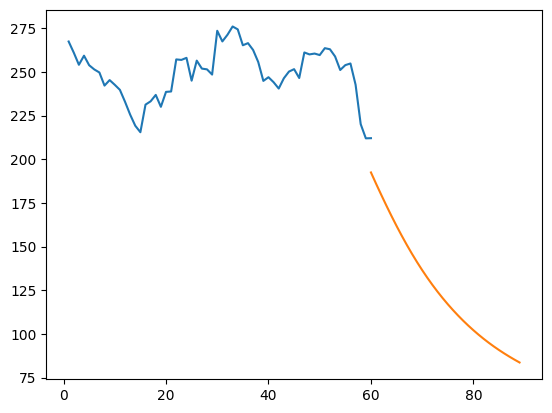

In [123]:
plt.plot(np.arange(1,61), y_test)
plt.plot(np.arange(60,90),forecast)